In [102]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
from sklearn.metrics import mean_squared_error


In [103]:
# Step 1: Load the Original Audio Signal
y, sr = librosa.load("guitar.wav", sr=None)

### Plotting the original signal

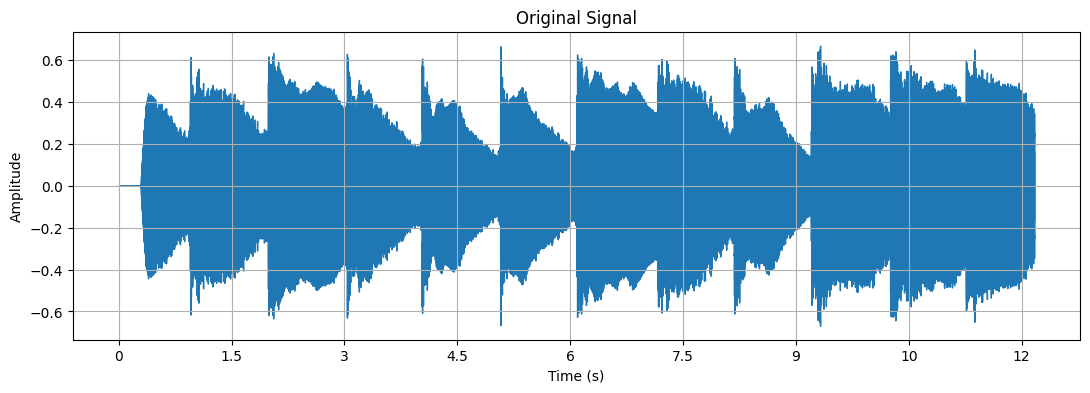

In [108]:
# Plotting the original signal
plt.figure(figsize=(13, 4))
librosa.display.waveshow(y)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### Calculate the FFT and Peak Frequency

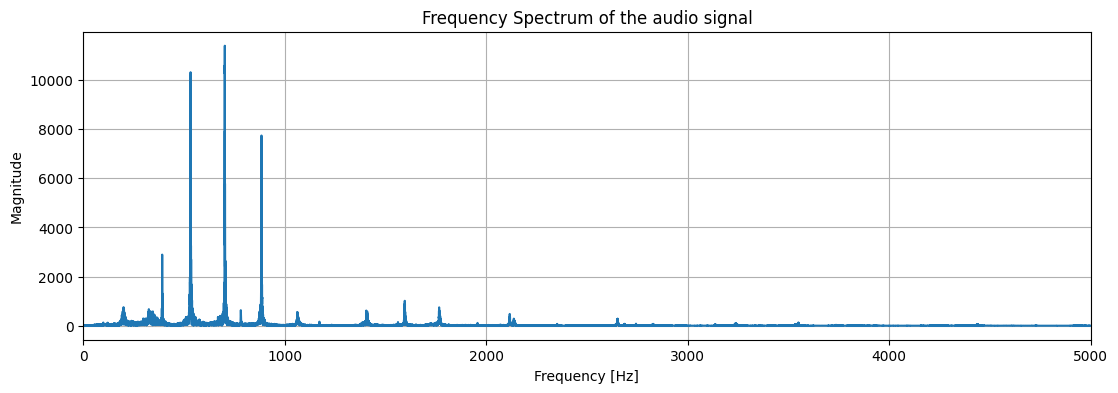

Peak Frequency: 702.97 Hz


In [109]:
# Perform Fast Fourier Transform (FFT)
audio_signal, sample_rate = librosa.load('guitar.wav', sr=None)
fft_result = np.fft.fft(audio_signal)
fft_magnitude = np.abs(fft_result)  # Magnitude of FFT
fft_frequency = np.fft.fftfreq(len(fft_result), d=1/sample_rate)  # Frequency bins

# Limit to positive frequencies
positive_frequencies = fft_frequency[:len(fft_frequency) // 2]
positive_magnitude = fft_magnitude[:len(fft_magnitude) // 2]

# Plot the frequency spectrum
plt.figure(figsize=(13, 4))
plt.plot(positive_frequencies, positive_magnitude)
plt.title("Frequency Spectrum of the audio signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.xlim(0, 5000)  # Limit to 20 kHz for better visibility
plt.grid()
plt.show()

# Find the peak frequency
peak_index = np.argmax(Y_magnitude)
peak_frequency = abs(frequency[peak_index])  # Absolute value of the peak frequency
print(f"Peak Frequency: {peak_frequency:.2f} Hz")


### Calculate Nyquist Rate (Twice the Peak Frequency)

In [89]:
undersampled_sr = 1.65*peak_frequency
nyquist_rate = 2 * peak_frequency
oversampled_sr = 2.35*peak_frequency

# Resampling
y_undersampled = librosa.resample(y, orig_sr=sr, target_sr = undersampled_sr)
y_resampled = librosa.resample(y, orig_sr=sr, target_sr = nyquist_rate)
y_oversampled = librosa.resample(y, orig_sr=sr, target_sr = oversampled_sr)


### Normalizing the sampled signal

In [90]:
y_under_normalized = y_undersampled / np.max(np.abs(y_undersampled))
y_normalized = y_resampled / np.max(np.abs(y_resampled))
y_over_normalized = y_oversampled / np.max(np.abs(y_oversampled))

### Plot the undersampled , resampled , oversampled audio signal

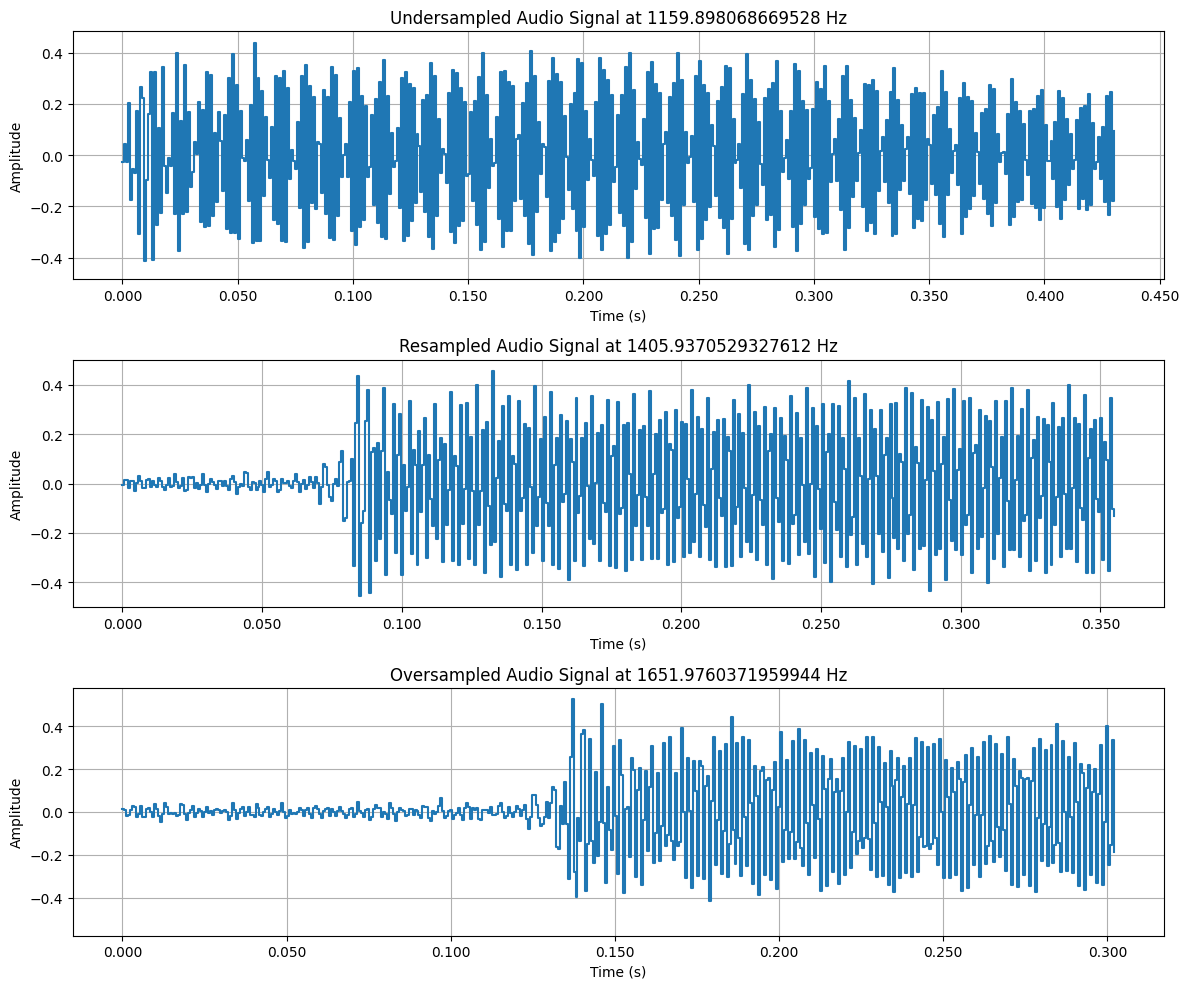

In [91]:
sample_start = 500
sample_end = 1000

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Plot the undersampled audio signal
axs[0].set_title(f'Undersampled Audio Signal at {undersampled_sr} Hz')
librosa.display.waveshow(y_undersampled[sample_start:sample_end], sr=undersampled_sr, ax=axs[0])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True)

# Plot the resampled audio signal
axs[1].set_title(f'Resampled Audio Signal at {nyquist_rate} Hz')
librosa.display.waveshow(y_resampled[sample_start:sample_end], sr=nyquist_rate, ax=axs[1])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[1].grid(True)

# Plot the oversampled audio signal
axs[2].set_title(f'Oversampled Audio Signal at {oversampled_sr} Hz')
librosa.display.waveshow(y_oversampled[sample_start:sample_end], sr=oversampled_sr, ax=axs[2])
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Amplitude')
axs[2].grid(True)

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


### Perform DPCM Encoding/Decoding for undersampled, resampled, and oversampled signals

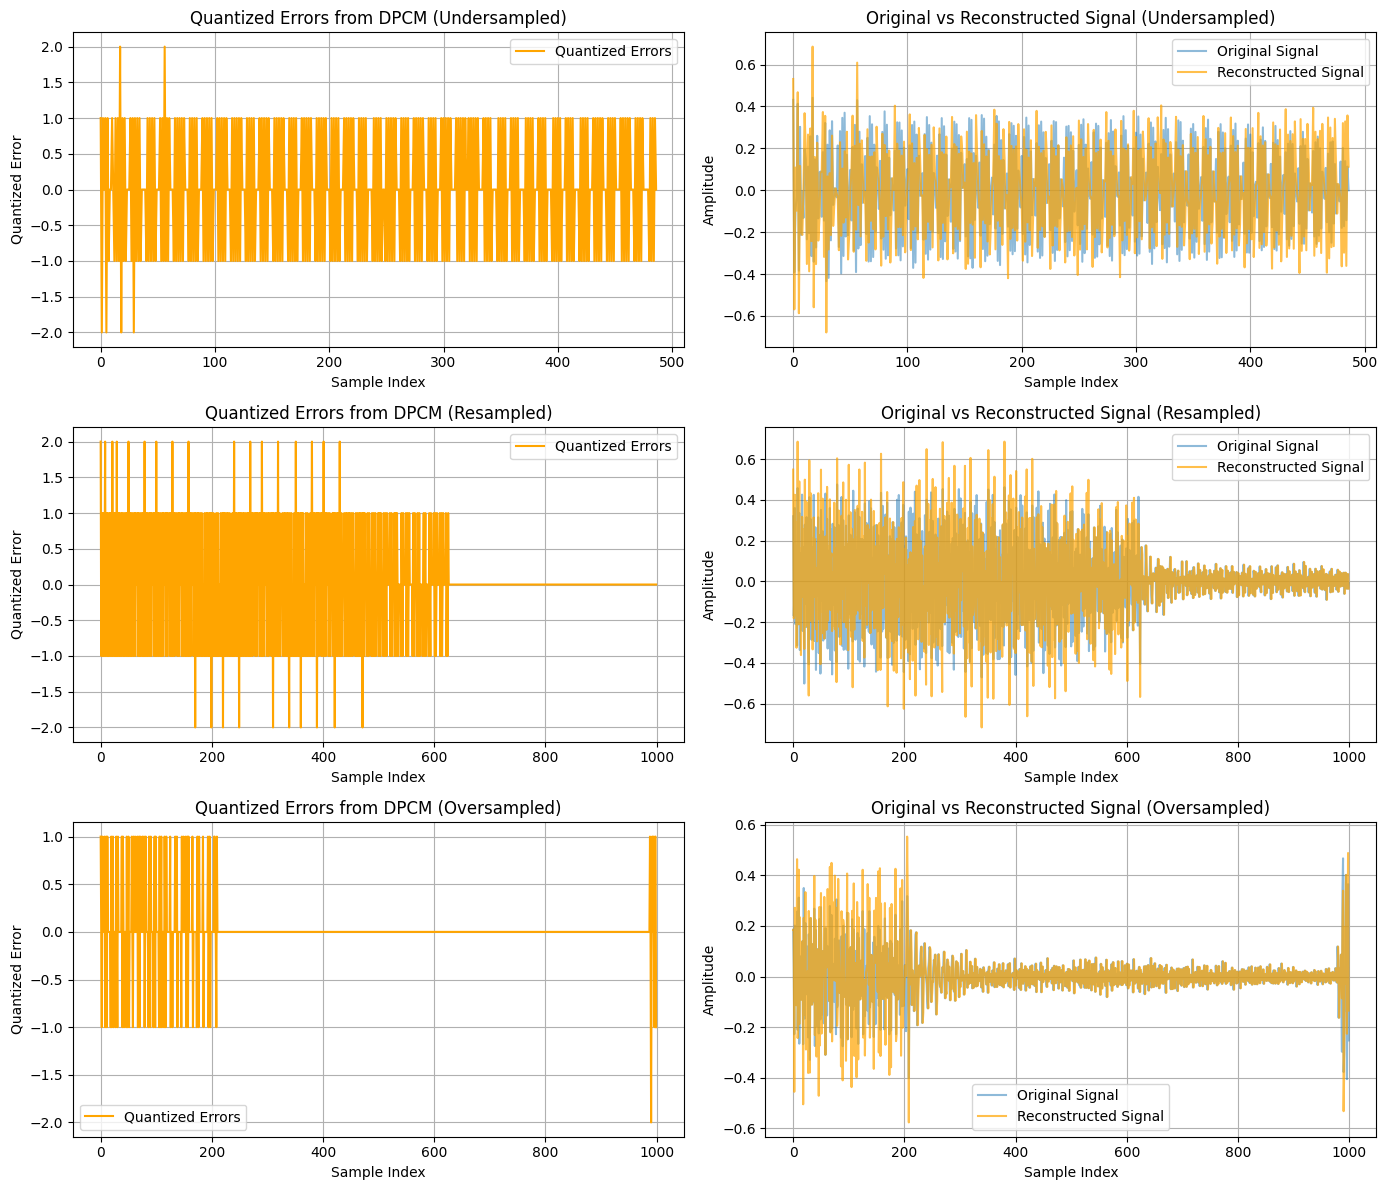

Undersampled - MSE: 0.017866, Correlation Coefficient: 0.836817
Resampled - MSE: 0.015520, Correlation Coefficient: 0.824951
Oversampled - MSE: 0.006773, Correlation Coefficient: 0.697554


In [95]:
# Step 4: DPCM Encoding Function
def dpcm_encode(signal, quantization_levels=16):
    # Initialize variables
    predictions = np.zeros(len(signal))
    errors = np.zeros(len(signal))
    quantized_errors = np.zeros(len(signal), dtype=np.int16)

    # Prediction and error calculation
    for n in range(1, len(signal)):
        predictions[n] = signal[n - 1]  # Simple prediction: previous sample
        errors[n] = signal[n] - predictions[n]  # Calculate error
        quantized_errors[n] = np.round(errors[n] * (quantization_levels / 2)).astype(np.int16)  # Quantize error

    return quantized_errors, predictions

# Step 5: DPCM Decoding Function
def dpcm_decode(quantized_errors, predictions, quantization_levels=16):
    # Reconstruct the signal from quantized errors
    reconstructed_signal = np.zeros(len(quantized_errors))

    for n in range(1, len(quantized_errors)):
        reconstructed_signal[n] = predictions[n] + quantized_errors[n] / (quantization_levels / 2)  # Decode the signal

    return reconstructed_signal

# Perform DPCM Encoding/Decoding for undersampled, resampled, and oversampled signals
signals = {
    "Undersampled": y_undersampled,
    "Resampled": y_resampled,
    "Oversampled": y_oversampled
}

sample_start = 6000
sample_end = 7000

# To store MSE and Correlation Coefficient results for each case
metrics = []

# Plot for each case (longitudinal layout)
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

for i, (title, signal) in enumerate(signals.items()):
    # Perform DPCM encoding
    quantized_errors, predictions = dpcm_encode(signal)

    # Perform DPCM decoding
    reconstructed_signal = dpcm_decode(quantized_errors, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(signal[sample_start:sample_end], reconstructed_signal[sample_start:sample_end])

    # Calculate Correlation Coefficient
    correlation_coefficient = np.corrcoef(signal[sample_start:sample_end], reconstructed_signal[sample_start:sample_end])[0, 1]

    # Store metrics
    metrics.append((title, mse, correlation_coefficient))

    # Plot the quantized errors (encoded signal)
    axs[i, 0].plot(quantized_errors[sample_start:sample_end], label='Quantized Errors', color='orange')
    axs[i, 0].set_title(f'Quantized Errors from DPCM ({title})')
    axs[i, 0].set_xlabel('Sample Index')
    axs[i, 0].set_ylabel('Quantized Error')
    axs[i, 0].grid(True)
    axs[i, 0].legend()

    # Plot the original and reconstructed signal together
    axs[i, 1].plot(signal[sample_start:sample_end], label='Original Signal', alpha=0.5)
    axs[i, 1].plot(reconstructed_signal[sample_start:sample_end], label='Reconstructed Signal', color='orange', alpha=0.7)
    axs[i, 1].set_title(f'Original vs Reconstructed Signal ({title})')
    axs[i, 1].set_xlabel('Sample Index')
    axs[i, 1].set_ylabel('Amplitude')
    axs[i, 1].grid(True)
    axs[i, 1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Print the error metrics (MSE and Correlation Coefficient) for each signal
for title, mse, corr in metrics:
    print(f'{title} - MSE: {mse:.6f}, Correlation Coefficient: {corr:.6f}')


Reconstructed signal for Undersampled saved as Undersampled_reconstructed.wav
Reconstructed signal for Resampled saved as Resampled_reconstructed.wav
Reconstructed signal for Oversampled saved as Oversampled_reconstructed.wav
